# Nepali Handwritten Character Recognition Using CNN
---

This notebook demonstrates the implementation of convolutional neural networks for training deep learning models that is capable of identifying handwritten Nepali characters.

- Author: Dipesh Jung Pandey

# Table of Contents

1. Overview
2. Data Preparation
3. Baseline Model (Model A)
4. Extended Model (Model B)
6. Artificial Neural Network Model (Model C)
7. Observation
---

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## 1. Overview

#### Convolutional Neural Networks

Convolutional neural networks are deep learning algorithms that are most commonly used for training machines to recognize and predict objects from input images. An example of a convolutional neural network is shown in the figure below.<br><br>


![convnet](images/convnet.png)

<br><br>
In this notebook, we will implement multiple variations of convolutional neural networks to recognize and predict Nepali handwritten characters from an input image. Each model will be initialized with a different set of parameters but will remain consistent on the pattern of layers that are used. Each model will be evaluated and compared at the end of the notebook.  

<br>

#### Dataset

- The dataset used here is the DHCD dataset which contains 92,000 images and its corresponding labels of Nepali handwritten characters. 
- The dataset is stored in `.npz` file format and consumes a total storage of 90.5 MB. 
- The dataset is accessible in the link provided <a href="https://github.com/Prasanna1991/DHCD_Dataset">here</a>.
- The images in the dataset have already been divided into training and test sets with 85% training examples and 15% test examples. 
- Each image is a grayscale image with pixel values ranging from 0-255. 
- Each image is also pre-processed with a padding of 2 pixels on all sides. Since the total size of each image is 32x32 pixels, each character is actually contained within a 28x28 pixel dimension. 

Details of the dataset are summarized in the table shown below. 

<br>


| Data                  |# Examples   |  Shape             |
|-----------------------|-------------|--------------------|
| Training set images   | 78200   	  | (78200, 32, 32)    |
| Training set labels   | 78200       | (78200, )          |
| Test set images       | 13800       | (13800, 32, 32)    |
| Test set labels       |  13800      | (13800, )          |
    


## 2. Data Preparation 

In [2]:
# Load dataset
data_npz = np.load("dataset/dataset.npz")

# Training examples
img_train = data_npz['arr_0']
lbl_train = data_npz['arr_1']

# Test examples
img_test = data_npz['arr_2']
lbl_test = data_npz['arr_3']

print("Number of training examples: {}".format(len(img_train)))
print("Number of test examples: {}".format(len(img_test)))

Number of training examples: 78200
Number of test examples: 13800


The dataset is initially arranged in an ascending sequence of characters and digits. This may have an undesired affect on the learning process of the neural network. To avoid this from happening, the dataset is shuffled while retaining the index of each image and its corresponding label.

In [3]:
# Define function to shuffle data
def shuffle_dataset(img_train, lbl_train, img_test, lbl_test):
    image_train, label_train = shuffle(img_train, lbl_train)
    image_test, label_test = shuffle(img_test, lbl_test)
    return (image_train, label_train), (image_test, label_test)

In [4]:
(image_train, label_train), (image_test, label_test) = shuffle_dataset(img_train, lbl_train, img_test, lbl_test)

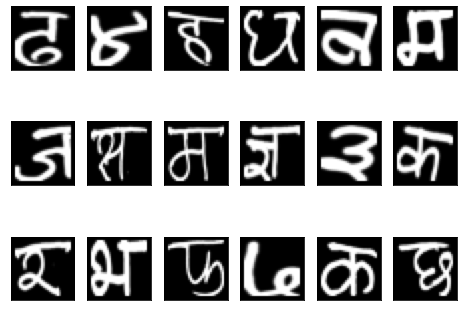

In [5]:
# Plot a few examples
fig = plt.figure(figsize=(8,6))
rows = 3
columns = 6
for i in range(1, rows*columns+1):
    img = image_train[23+i]
    fig.add_subplot(rows, columns, i)
    ax= plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

In [6]:
# Examine a single image instance
print("Image matrix:\n\n{}\n".format(image_train[28]))
print("Dimension: {}".format(image_train[28].shape))
print("Minimum pixel value: {}".format(np.min(image_train[28])))
print("Maximum pixel value: {}".format(np.max(image_train[28])))

Image matrix:

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0 238 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Dimension: (32, 32)
Minimum pixel value: 0
Maximum pixel value: 255


To implement the neural network using the Keras framework, the shape of the images must be changed to contain the number of channels on each image. In our case of grayscale images, this number will be equal to 1 for all examples.

We will also normalize the pixel values of images from 0-255 to a range of 0-1 for more efficient computation when training the neural network.

In [7]:
# reshape to [samples][width][height][channels]
image_train = image_train.reshape(-1, 32, 32, 1).astype('float32')
image_test = image_test.reshape(-1, 32, 32, 1).astype('float32')

#normalize inputs to 0-1 from 0-255
image_train = image_train/255
image_test = image_test/255

print("Shape of training set: {}".format(image_train.shape))
print("Shape of test set: {}".format(image_test.shape))
print("Minimum pixel value: {}".format(np.min(image_train[28])))
print("Maximum pixel value: {}".format(np.max(image_train[28])))

Shape of training set: (78200, 32, 32, 1)
Shape of test set: (13800, 32, 32, 1)
Minimum pixel value: 0.0
Maximum pixel value: 1.0


Each image label in the dataset is assigned an integer value which represents a class in the set of possible character classses in the Nepali language. This process known as integer encoding and is demonstrated below:

In [8]:
print(label_train)

[ 3 37 45 ... 38 31 36]


However, for categorical datasets, integer encoding is not sufficient. Integer encoding assumes ordinal relationship between classes which can have undesirable consequences while classifying character images. To prevent this from happening, we will use a binarization technique known as one-hot encoding. This method will convert the integers into a set a binary values where the position of the true value indicates the category of the classified image.

Since the integers encoded in the labels range from 1-46, we will have to convert it into the range of 0-45 for proper one-hot encoding of the labels.

In [9]:
# convert to range 0-45
label_train = label_train -1
label_test = label_test - 1
# one-hot encode output classes
label_train = keras.utils.to_categorical(label_train, num_classes=46, dtype='float32')
label_test = keras.utils.to_categorical(label_test, num_classes=46, dtype='float32')

print(label_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 3. Baseline Model


In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD

We will first develop a simple baseline model to demonstrate the fundamental steps in building a simple convolutional neural network. Afterwards, we will explore more complex models and make comparisions to the baseline model.

Model description:

- The baseline model contains 1 convolution layer, 1 max pooling layer, 1 flattening layer and 2 fully connected layers. 
- The convolution layer contains 32 units with a kernel size of 5 each. 
- A ReLU activation function is applied on the ouput of the convolution operation. 
- The max pooling layer follows the convolution layer using a pool size of 2 pixels. 
- The reduced output from the pooling layer is then flattened into a one dimensional vector input. 
- A fully connected layer is able to process the vector and apply another ReLU activation function. 
- A final fully connected layer applies the multi-class logistic function called softmax function to generate the final output vector.
- The first fully connected layer contains 400 units and the final fully connected layer included units equivalent to the number of classes in the classification problem 46.
- The model uses a gradient descent technique known as stochastic gradient descent (SGD). A learning rate of 0.01 and a momentum of 0.9 is applied on the gradient descent. 
- The loss is evaluated using cross entropy for categorical data. 
- The model is specified to provide data for the accuracy when training the model.

<br>

In [11]:
def baselineModel():
    # define model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=(32,32,1)))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(46, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Initialize model and display summary
baseline_model = baselineModel()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               2509200   
_________________________________________________________________
dense_1 (Dense)              (None, 46)                18446     
Total params: 2,528,478
Trainable params: 2,528,478
Non-trainable params: 0
_________________________________________________________________


We will run the model for 20 epochs with a batch size of 128 inputs per batch. The data will be shuffled on each epoch which helps reduce biased estimation of the true gradient.

In [13]:
history = baseline_model.fit(
                image_train, 
                label_train, 
                validation_data=(image_test, label_test), 
                epochs=20, 
                batch_size=128,
                shuffle=True,
                verbose=1)

Epoch 1/20
611/611 [==============================] - 7s 6ms/step - loss: 3.1114 - accuracy: 0.2526 - val_loss: 1.2137 - val_accuracy: 0.6809
Epoch 2/20
611/611 [==============================] - 3s 6ms/step - loss: 1.1710 - accuracy: 0.6888 - val_loss: 0.9412 - val_accuracy: 0.7443
Epoch 3/20
611/611 [==============================] - 3s 6ms/step - loss: 0.9056 - accuracy: 0.7593 - val_loss: 0.7354 - val_accuracy: 0.8021
Epoch 4/20
611/611 [==============================] - 3s 6ms/step - loss: 0.7096 - accuracy: 0.8102 - val_loss: 0.6196 - val_accuracy: 0.8345
Epoch 5/20
611/611 [==============================] - 3s 6ms/step - loss: 0.5795 - accuracy: 0.8426 - val_loss: 0.5197 - val_accuracy: 0.8620
Epoch 6/20
611/611 [==============================] - 3s 6ms/step - loss: 0.4921 - accuracy: 0.8663 - val_loss: 0.4567 - val_accuracy: 0.8752
Epoch 7/20
611/611 [==============================] - 3s 6ms/step - loss: 0.4114 - accuracy: 0.8874 - val_loss: 0.4225 - val_accuracy: 0.8814
Epoch 

In [14]:
baseline_model.evaluate(image_test, label_test, verbose=0, batch_size=128)

[0.20656348764896393, 0.942463755607605]

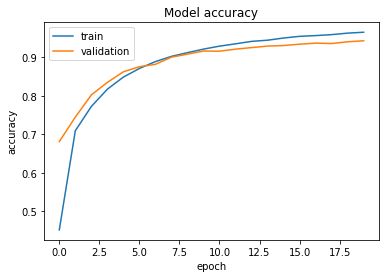

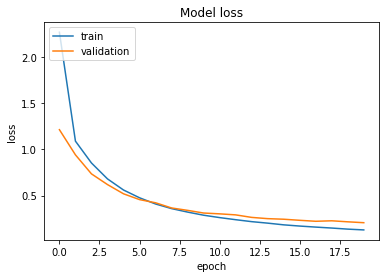

In [15]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Observation

The graph plotted above demonstrates the progress of training and validating the neural network on each iteration with respect to accuracy and loss. Following the 8<sup>th</sup> epoch, we can observe a relative improvement in accuracy and loss of training examples compared to validation examples. Nonetheless, we find a gradual increase in validation accuracy and a gradual decrease in validation loss which indicates that the model is still improving with each iteration of gradient descent. The baseline model has resulted in a test accuracy of around `94%` and test loss of approximately `0.21`, which is astonishingly exceptional given the simplicity of the model used here. This may be attributed by factors such as the amount and quality of data available, effectiveness of the convolutional neural network architecture and selection of gradient descent and loss functions.

## 4. Extended Model

We will now attempt to improve upon the baseline model used previously by building a more accurate model. We will utilize more convolution layers for improving the model's feature detection capability. We will build a deeper neural network by adding more layers and learning units to our model. To prevent overfitting the model, we will make use of two regularization techniques- dropout and data augmentation.

We begin by initializing and preparing a new instance of the dataset.

In [27]:
# initialize training and test data
(image_train, label_train), (image_test, label_test) = shuffle_dataset(img_train, lbl_train, img_test, lbl_test)

# reshape to [samples][width][height][channels]
image_train = image_train.reshape(-1, 32, 32, 1).astype('float32')
image_test = image_test.reshape(-1, 32, 32, 1).astype('float32')

# normalize inputs to 0-1 from 0-255
image_train = image_train/255
image_test = image_test/255

# convert to range 0-45
label_train = label_train -1
label_test = label_test - 1

# one-hot encode output classes
label_train = keras.utils.to_categorical(label_train)
label_test = keras.utils.to_categorical(label_test)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Upon exprimenting with various data augmentation techniques, the following three augmentations were selected for implementing while training the model. These augmentations include:

- Shear
- Zoom
- Shift

The parameters for these augmentation methods were selected carefully by applying and observing various transformations with consideration towards the possible impact on traning the model. Examples of these augmentations are shown below.

Shear: 


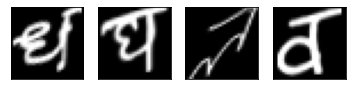

In [18]:
# Shear
print("Shear: ")

# Generate shear
train_datagen = ImageDataGenerator(
    shear_range=40)

# Plot
fig = plt.figure(figsize=(6,2))
i = 1
rows = 1
columns = 4
for batch in train_datagen.flow(image_train, batch_size=1):
    aug_img = batch[0].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    ax= plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(aug_img, cmap=plt.get_cmap('gray'))  
    if i > 3:
        break
    i+=1

Zoom: 


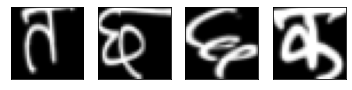

In [19]:
# Zoom
print("Zoom: ")

# Generate zoom
train_datagen = ImageDataGenerator(
    zoom_range=[0.8,0.9])

# Plot
fig = plt.figure(figsize=(6,2))
i = 1
rows = 1
columns = 4
for batch in train_datagen.flow(image_train, batch_size=1):
    aug_img = batch[0].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    ax= plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(aug_img, cmap=plt.get_cmap('gray'))  
    if i > 3:
        break
    i+=1

Shifts: 


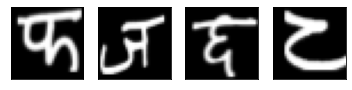

In [20]:
# Horizantal and Vertical Shift
print("Shifts: ")

# Generate shifts
train_datagen = ImageDataGenerator(
    height_shift_range=0.1,
    width_shift_range=0.1)

# Plot
fig = plt.figure(figsize=(6,2))
i = 1
rows = 1
columns = 4
for batch in train_datagen.flow(image_train, batch_size=1):
    aug_img = batch[0].reshape(32,32)
    fig.add_subplot(rows, columns, i)
    ax= plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(aug_img, cmap=plt.get_cmap('gray'))  
    if i > 3:
        break
    i+=1

In [21]:
# Final augmented data generation
train_datagen = ImageDataGenerator(
    shear_range=40,
    zoom_range=[0.8,0.9],
    height_shift_range=0.1,
    width_shift_range=0.1)

In [22]:
# train_datagen.fit(image_train)

In [23]:
from tensorflow.keras.layers import Dropout

In [24]:
def extendedModel():
    # define model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(32,32,1), padding='same'))
    model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=5, activation='relu'))
    model.add(Conv2D(64, kernel_size=5, activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(400, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(46, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
# Initialize model and display summary
extended_model = extendedModel()
extended_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)         

In [29]:
xtd_history = extended_model.fit(
                image_train, 
                label_train,
                validation_data=(image_test, label_test),
                epochs=20,
                batch_size=128,
                shuffle=True,
                verbose=1)

Epoch 1/20
611/611 [==============================] - 9s 14ms/step - loss: 3.8124 - accuracy: 0.0299 - val_loss: 2.8094 - val_accuracy: 0.2866
Epoch 2/20
611/611 [==============================] - 8s 14ms/step - loss: 2.0993 - accuracy: 0.4316 - val_loss: 0.7616 - val_accuracy: 0.7870
Epoch 3/20
611/611 [==============================] - 8s 14ms/step - loss: 0.8587 - accuracy: 0.7518 - val_loss: 0.4719 - val_accuracy: 0.8610
Epoch 4/20
611/611 [==============================] - 8s 14ms/step - loss: 0.5745 - accuracy: 0.8303 - val_loss: 0.3409 - val_accuracy: 0.8989
Epoch 5/20
611/611 [==============================] - 8s 14ms/step - loss: 0.4340 - accuracy: 0.8690 - val_loss: 0.2751 - val_accuracy: 0.9167
Epoch 6/20
611/611 [==============================] - 8s 14ms/step - loss: 0.3626 - accuracy: 0.8904 - val_loss: 0.2255 - val_accuracy: 0.9322
Epoch 7/20
611/611 [==============================] - 8s 14ms/step - loss: 0.3109 - accuracy: 0.9038 - val_loss: 0.1995 - val_accuracy: 0.9382

In [30]:
extended_model.evaluate(image_test, label_test, verbose=0, batch_size=128)

[0.10860665887594223, 0.9700724482536316]

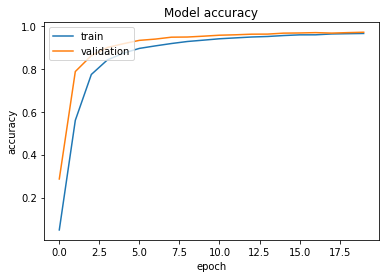

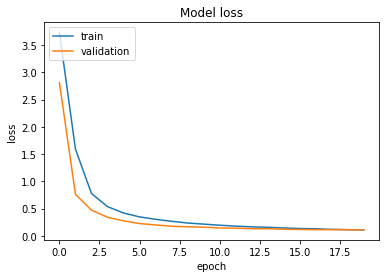

In [31]:
# Accuracy
plt.plot(xtd_history.history['accuracy'])
plt.plot(xtd_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(xtd_history.history['loss'])
plt.plot(xtd_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()